In [1]:
import warnings 
warnings.filterwarnings("ignore")

from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Invertd,
    LabelFilterd,
    LoadImaged,
    RandFlipd,
    RandSpatialCropd,
    RandZoomd,
    Resized,
    ScaleIntensityRanged,
    SpatialCrop,
    SpatialCropd,
    ToTensord,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob

import numpy as np

import itk

import site
site.addsitedir('../../../ARGUS')
from ARGUSUtils_Transforms import *

In [2]:
img1_dir = "../../../Data/VFoldData/BAMC-PTX*Sliding-Annotations-Linear/"
    
all_images = sorted(glob(os.path.join(img1_dir, '*_?????.nii.gz')))
all_labels = sorted(glob(os.path.join(img1_dir, '*.extruded-overlay-NS.nii.gz')))

gpu_device = 1

num_folds = 15

num_classes = 3

num_workers_tr = 4
batch_size_tr = 8
num_workers_vl = 2
batch_size_vl = 1

num_slices = 48
size_x = 320
size_y = 320

max_epochs = 500
net_channels=(32, 64, 64)
net_strides=(2, 2)

model_filename_base = "./results/BAMC_PTX_3DUNet-NS-Extruded.best_model.vfold"

num_images = len(all_images)
print(num_images)

ns_prefix = ['025ns','026ns','027ns','035ns','048ns','055ns','117ns',
             '135ns','193ns','210ns','215ns','218ns','219ns','221ns','247ns']
s_prefix = ['004s','019s','030s','034s','037s','043s','065s','081s',
            '206s','208s','211s','212s','224s','228s','236s','237s']

fold_prefix_list = []
ns_count = 0
s_count = 0
for i in range(num_folds):
    if i%2 == 0:
        num_ns = 1
        num_s = 1
        if i > num_folds-3:
            num_s = 2
    else:
        num_ns = 1
        num_s = 1
    f = []
    for ns in range(num_ns):
        f.append([ns_prefix[ns_count+ns]])
    ns_count += num_ns
    for s in range(num_s):
        f.append([s_prefix[s_count+s]])
    s_count += num_s
    fold_prefix_list.append(f)
        
train_files = []
val_files = []
test_files = []
for i in range(num_folds):
    tr_folds = []
    for f in range(i,i+num_folds-2):
        tr_folds.append(fold_prefix_list[f%num_folds])
    tr_folds = list(np.concatenate(tr_folds).flat)
    va_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-2) % num_folds]).flat)
    te_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-1) % num_folds]).flat)
    train_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in tr_folds)],
                    [se for se in all_labels if any(pref in se for pref in tr_folds)])
            ]
        )
    val_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in va_folds)],
                    [se for se in all_labels if any(pref in se for pref in va_folds)])
            ]
        )
    test_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in te_folds)],
                    [se for se in all_labels if any(pref in se for pref in te_folds)])
            ]
        )
    print(len(train_files[i]),len(val_files[i]),len(test_files[i]))

62
53 4 5
53 5 4
54 4 4
54 4 4
54 4 4
55 4 3
55 3 4
54 4 4
54 4 4
54 4 4
53 4 5
53 5 4
53 4 5
53 5 4
54 4 4


../../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/025ns_image_267456908021_clean.nii.gz
../../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/025ns_image_267456908021_clean.extruded-overlay-NS.nii.gz


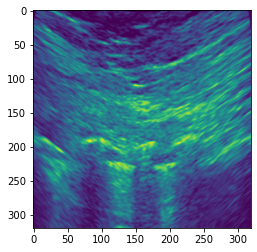

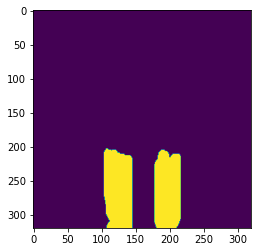

In [3]:
imgnum = 1 #10 for ns, 0 for s

print(train_files[0][imgnum]["image"])
print(train_files[0][imgnum]["label"])

img = itk.imread(train_files[0][imgnum]["image"])
arrimg = itk.GetArrayFromImage(img)
img = itk.imread(train_files[0][imgnum]["label"])
arrlbl = itk.GetArrayFromImage(img)

plt.subplots()
plt.imshow(arrimg[0,:,:])
plt.subplots()
plt.imshow(arrlbl[0,:,:])


In [4]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityRanged(keys=["image"],
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0),
        Resized(keys=["image", "label"],
            spatial_size=[320,320,60],
            mode=['trilinear', 'nearest']),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=num_slices,
            axis=3,
            keys=['image', 'label']),
        RandFlipd(prob=0.5, 
            spatial_axis=2,
            keys=['image', 'label']),
        RandFlipd(prob=0.5, 
            spatial_axis=0,
            keys=['image', 'label']),
        RandZoomd(prob=0.5, 
            min_zoom=1.0,
            max_zoom=1.2,
            keys=['image', 'label'],
            keep_size=True,
            mode=['trilinear', 'nearest']),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityRanged(keys=["image"],
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0),
        Resized(keys=["image", "label"],
            spatial_size=[320,320,60],
            mode=['trilinear', 'nearest']),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=num_slices,
            axis=3,
            center_slice=30,
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)

In [5]:
train_ds = [CacheDataset(data=train_files[i], transform=train_transforms,cache_rate=1.0, num_workers=num_workers_tr)
            for i in range(num_folds)]
train_loader = [DataLoader(train_ds[i], batch_size=batch_size_tr, shuffle=True, num_workers=num_workers_tr) 
                for i in range(num_folds)]

val_ds = [CacheDataset(data=val_files[i], transform=val_transforms, cache_rate=1.0, num_workers=num_workers_vl)
          for i in range(num_folds)]
val_loader = [DataLoader(val_ds[i], batch_size=batch_size_vl, num_workers=num_workers_vl)
              for i in range(num_folds)]

Loading dataset: 100%|████████████████████████████| 4/4 [00:00<00:00,  5.51it/s]


torch.Size([1, 1, 320, 320, 48])
torch.Size([320, 320, 48])
image shape: torch.Size([320, 320, 48]), label shape: torch.Size([320, 320, 48])


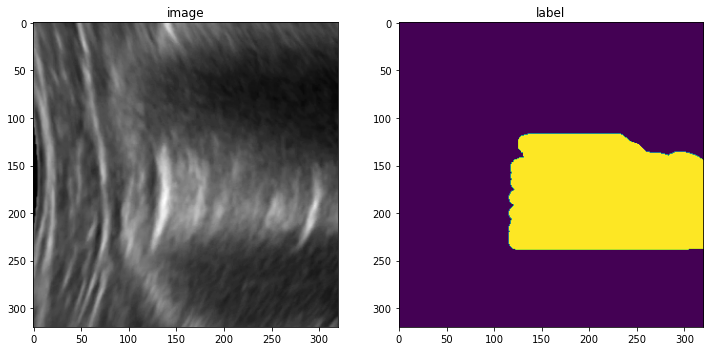

tensor(0.) tensor(1.)


In [6]:
imgnum = 0
check_data = first(val_loader[0])
image, label = (check_data["image"][imgnum][0], check_data["label"][imgnum][0])
print(check_data["image"].shape)
print(image.shape)
print(f"image shape: {image.shape}, label shape: {label.shape}")
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 2], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 2])
plt.show()
print(label.min(), label.max())

In [7]:
device = torch.device("cuda:"+str(gpu_device))

In [8]:
def vfold_train(vfold_num, train_loader, val_loader):
    model = UNet(
        dimensions=3,
        in_channels=1,
        out_channels=num_classes,
        channels=net_channels,
        strides=net_strides,
        num_res_units=2,
        norm=Norm.BATCH,
    ).to(device)
    loss_function = DiceLoss(to_onehot_y=True, softmax=True)
    optimizer = torch.optim.Adam(model.parameters(), 1e-4)
    dice_metric = DiceMetric(include_background=False, reduction="mean")

    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []

    post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, num_classes=num_classes)])
    post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, num_classes=num_classes)])

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"{vfold_num}: epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(f"{step}/{len(train_ds) // train_loader.batch_size}, "
                  f"train_loss: {loss.item():.4f}")
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"{vfold_num} epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )
                    roi_size = (size_x, size_y, num_slices)
                    sw_batch_size = batch_size_vl
                    val_outputs = sliding_window_inference(
                        val_inputs, roi_size, sw_batch_size, model)
                    val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                    val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                    # compute metric for current iteration
                    dice_metric(y_pred=val_outputs, y=val_labels)

                # aggregate the final mean dice result
                metric = dice_metric.aggregate().item()
                # reset the status for next validation round
                dice_metric.reset()

                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), model_filename_base+'_'+str(vfold_num)+'.pth')
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )

    np.save(model_filename_base+"_loss_"+str(vfold_num)+".npy", epoch_loss_values)
    np.save(model_filename_base+"_val_dice_"+str(vfold_num)+".npy", metric_values)

In [9]:
for i in range(gpu_device,num_folds,4):
    vfold_train(i, train_loader[i], val_loader[i])    

----------
1: epoch 1/500
1/1, train_loss: 0.7663
2/1, train_loss: 0.7541
3/1, train_loss: 0.7572
4/1, train_loss: 0.7454
5/1, train_loss: 0.7522
6/1, train_loss: 0.7354
7/1, train_loss: 0.7368
1 epoch 1 average loss: 0.7496
----------
1: epoch 2/500
1/1, train_loss: 0.7307
2/1, train_loss: 0.7281
3/1, train_loss: 0.7371
4/1, train_loss: 0.7259
5/1, train_loss: 0.7191
6/1, train_loss: 0.7166
7/1, train_loss: 0.7215
1 epoch 2 average loss: 0.7256
saved new best metric model
current epoch: 2 current mean dice: 0.1954
best mean dice: 0.1954 at epoch: 2
----------
1: epoch 3/500
1/1, train_loss: 0.7196
2/1, train_loss: 0.7150
3/1, train_loss: 0.7139
4/1, train_loss: 0.7162
5/1, train_loss: 0.7068
6/1, train_loss: 0.7165
7/1, train_loss: 0.6988
1 epoch 3 average loss: 0.7124
----------
1: epoch 4/500
1/1, train_loss: 0.6961
2/1, train_loss: 0.7116
3/1, train_loss: 0.6993
4/1, train_loss: 0.6993
5/1, train_loss: 0.6955
6/1, train_loss: 0.7058
7/1, train_loss: 0.7191
1 epoch 4 average loss: 0

1/1, train_loss: 0.6037
2/1, train_loss: 0.5800
3/1, train_loss: 0.5555
4/1, train_loss: 0.5821
5/1, train_loss: 0.5981
6/1, train_loss: 0.5823
7/1, train_loss: 0.5797
1 epoch 31 average loss: 0.5830
----------
1: epoch 32/500
1/1, train_loss: 0.5813
2/1, train_loss: 0.6021
3/1, train_loss: 0.5987
4/1, train_loss: 0.5796
5/1, train_loss: 0.5543
6/1, train_loss: 0.5627
7/1, train_loss: 0.5698
1 epoch 32 average loss: 0.5784
current epoch: 32 current mean dice: 0.4158
best mean dice: 0.4651 at epoch: 28
----------
1: epoch 33/500
1/1, train_loss: 0.5726
2/1, train_loss: 0.5848
3/1, train_loss: 0.5855
4/1, train_loss: 0.6147
5/1, train_loss: 0.5669
6/1, train_loss: 0.5779
7/1, train_loss: 0.5757
1 epoch 33 average loss: 0.5826
----------
1: epoch 34/500
1/1, train_loss: 0.5719
2/1, train_loss: 0.5884
3/1, train_loss: 0.5681
4/1, train_loss: 0.5698
5/1, train_loss: 0.5936
6/1, train_loss: 0.5857
7/1, train_loss: 0.5762
1 epoch 34 average loss: 0.5791
current epoch: 34 current mean dice: 0.

4/1, train_loss: 0.5363
5/1, train_loss: 0.5168
6/1, train_loss: 0.5581
7/1, train_loss: 0.5441
1 epoch 61 average loss: 0.5322
----------
1: epoch 62/500
1/1, train_loss: 0.5314
2/1, train_loss: 0.5405
3/1, train_loss: 0.5559
4/1, train_loss: 0.5090
5/1, train_loss: 0.5301
6/1, train_loss: 0.5235
7/1, train_loss: 0.4828
1 epoch 62 average loss: 0.5247
current epoch: 62 current mean dice: 0.5659
best mean dice: 0.6078 at epoch: 52
----------
1: epoch 63/500
1/1, train_loss: 0.5098
2/1, train_loss: 0.5325
3/1, train_loss: 0.5269
4/1, train_loss: 0.5219
5/1, train_loss: 0.5181
6/1, train_loss: 0.5300
7/1, train_loss: 0.5231
1 epoch 63 average loss: 0.5232
----------
1: epoch 64/500
1/1, train_loss: 0.5288
2/1, train_loss: 0.5332
3/1, train_loss: 0.5211
4/1, train_loss: 0.5366
5/1, train_loss: 0.5165
6/1, train_loss: 0.5183
7/1, train_loss: 0.5414
1 epoch 64 average loss: 0.5280
current epoch: 64 current mean dice: 0.4876
best mean dice: 0.6078 at epoch: 52
----------
1: epoch 65/500
1/1,

1/1, train_loss: 0.4831
2/1, train_loss: 0.5086
3/1, train_loss: 0.4920
4/1, train_loss: 0.5483
5/1, train_loss: 0.4753
6/1, train_loss: 0.5014
7/1, train_loss: 0.4868
1 epoch 92 average loss: 0.4994
current epoch: 92 current mean dice: 0.5265
best mean dice: 0.6468 at epoch: 84
----------
1: epoch 93/500
1/1, train_loss: 0.4968
2/1, train_loss: 0.4794
3/1, train_loss: 0.4997
4/1, train_loss: 0.5071
5/1, train_loss: 0.4732
6/1, train_loss: 0.5058
7/1, train_loss: 0.5501
1 epoch 93 average loss: 0.5017
----------
1: epoch 94/500
1/1, train_loss: 0.4866
2/1, train_loss: 0.5185
3/1, train_loss: 0.4760
4/1, train_loss: 0.5172
5/1, train_loss: 0.4879
6/1, train_loss: 0.5072
7/1, train_loss: 0.4937
1 epoch 94 average loss: 0.4982
current epoch: 94 current mean dice: 0.6208
best mean dice: 0.6468 at epoch: 84
----------
1: epoch 95/500
1/1, train_loss: 0.5445
2/1, train_loss: 0.4956
3/1, train_loss: 0.5045
4/1, train_loss: 0.4856
5/1, train_loss: 0.5198
6/1, train_loss: 0.4757
7/1, train_loss

4/1, train_loss: 0.5146
5/1, train_loss: 0.4840
6/1, train_loss: 0.4926
7/1, train_loss: 0.4576
1 epoch 122 average loss: 0.4824
current epoch: 122 current mean dice: 0.6467
best mean dice: 0.6541 at epoch: 118
----------
1: epoch 123/500
1/1, train_loss: 0.4436
2/1, train_loss: 0.4860
3/1, train_loss: 0.4904
4/1, train_loss: 0.4600
5/1, train_loss: 0.4862
6/1, train_loss: 0.5110
7/1, train_loss: 0.4704
1 epoch 123 average loss: 0.4782
----------
1: epoch 124/500
1/1, train_loss: 0.4854
2/1, train_loss: 0.4489
3/1, train_loss: 0.4738
4/1, train_loss: 0.4668
5/1, train_loss: 0.4792
6/1, train_loss: 0.4881
7/1, train_loss: 0.4787
1 epoch 124 average loss: 0.4744
saved new best metric model
current epoch: 124 current mean dice: 0.6795
best mean dice: 0.6795 at epoch: 124
----------
1: epoch 125/500
1/1, train_loss: 0.4705
2/1, train_loss: 0.4694
3/1, train_loss: 0.4852
4/1, train_loss: 0.4833
5/1, train_loss: 0.4616
6/1, train_loss: 0.4674
7/1, train_loss: 0.4970
1 epoch 125 average loss:

7/1, train_loss: 0.4591
1 epoch 152 average loss: 0.4613
saved new best metric model
current epoch: 152 current mean dice: 0.6872
best mean dice: 0.6872 at epoch: 152
----------
1: epoch 153/500
1/1, train_loss: 0.4714
2/1, train_loss: 0.4686
3/1, train_loss: 0.4766
4/1, train_loss: 0.4603
5/1, train_loss: 0.4532
6/1, train_loss: 0.4859
7/1, train_loss: 0.4763
1 epoch 153 average loss: 0.4703
----------
1: epoch 154/500
1/1, train_loss: 0.4560
2/1, train_loss: 0.4586
3/1, train_loss: 0.4411
4/1, train_loss: 0.4802
5/1, train_loss: 0.4838
6/1, train_loss: 0.4600
7/1, train_loss: 0.4306
1 epoch 154 average loss: 0.4586
current epoch: 154 current mean dice: 0.6488
best mean dice: 0.6872 at epoch: 152
----------
1: epoch 155/500
1/1, train_loss: 0.4518
2/1, train_loss: 0.4376
3/1, train_loss: 0.4583
4/1, train_loss: 0.4728
5/1, train_loss: 0.4332
6/1, train_loss: 0.5086
7/1, train_loss: 0.4595
1 epoch 155 average loss: 0.4603
----------
1: epoch 156/500
1/1, train_loss: 0.4306
2/1, train_l

1/1, train_loss: 0.4336
2/1, train_loss: 0.4511
3/1, train_loss: 0.4638
4/1, train_loss: 0.4574
5/1, train_loss: 0.4712
6/1, train_loss: 0.4720
7/1, train_loss: 0.4518
1 epoch 183 average loss: 0.4572
----------
1: epoch 184/500
1/1, train_loss: 0.4369
2/1, train_loss: 0.4394
3/1, train_loss: 0.5025
4/1, train_loss: 0.4201
5/1, train_loss: 0.4461
6/1, train_loss: 0.4808
7/1, train_loss: 0.4410
1 epoch 184 average loss: 0.4524
current epoch: 184 current mean dice: 0.5045
best mean dice: 0.6872 at epoch: 152
----------
1: epoch 185/500
1/1, train_loss: 0.4720
2/1, train_loss: 0.4364
3/1, train_loss: 0.4440
4/1, train_loss: 0.4396
5/1, train_loss: 0.4695
6/1, train_loss: 0.4988
7/1, train_loss: 0.4308
1 epoch 185 average loss: 0.4559
----------
1: epoch 186/500
1/1, train_loss: 0.4477
2/1, train_loss: 0.4518
3/1, train_loss: 0.4714
4/1, train_loss: 0.4491
5/1, train_loss: 0.4594
6/1, train_loss: 0.4642
7/1, train_loss: 0.4716
1 epoch 186 average loss: 0.4593
current epoch: 186 current mea

5/1, train_loss: 0.4225
6/1, train_loss: 0.4209
7/1, train_loss: 0.4636
1 epoch 213 average loss: 0.4542
----------
1: epoch 214/500
1/1, train_loss: 0.4314
2/1, train_loss: 0.4595
3/1, train_loss: 0.4576
4/1, train_loss: 0.4774
5/1, train_loss: 0.4410
6/1, train_loss: 0.4471
7/1, train_loss: 0.4328
1 epoch 214 average loss: 0.4495
current epoch: 214 current mean dice: 0.6552
best mean dice: 0.6872 at epoch: 152
----------
1: epoch 215/500
1/1, train_loss: 0.4706
2/1, train_loss: 0.4598
3/1, train_loss: 0.4565
4/1, train_loss: 0.4826
5/1, train_loss: 0.4129
6/1, train_loss: 0.4523
7/1, train_loss: 0.4193
1 epoch 215 average loss: 0.4506
----------
1: epoch 216/500
1/1, train_loss: 0.4305
2/1, train_loss: 0.4255
3/1, train_loss: 0.4573
4/1, train_loss: 0.4669
5/1, train_loss: 0.4546
6/1, train_loss: 0.4682
7/1, train_loss: 0.4552
1 epoch 216 average loss: 0.4512
current epoch: 216 current mean dice: 0.4931
best mean dice: 0.6872 at epoch: 152
----------
1: epoch 217/500
1/1, train_loss:

1 epoch 243 average loss: 0.4455
----------
1: epoch 244/500
1/1, train_loss: 0.4121
2/1, train_loss: 0.4320
3/1, train_loss: 0.4491
4/1, train_loss: 0.4385
5/1, train_loss: 0.4384
6/1, train_loss: 0.4612
7/1, train_loss: 0.4307
1 epoch 244 average loss: 0.4374
current epoch: 244 current mean dice: 0.6042
best mean dice: 0.7011 at epoch: 240
----------
1: epoch 245/500
1/1, train_loss: 0.4443
2/1, train_loss: 0.4738
3/1, train_loss: 0.4448
4/1, train_loss: 0.4263
5/1, train_loss: 0.4378
6/1, train_loss: 0.4361
7/1, train_loss: 0.4360
1 epoch 245 average loss: 0.4427
----------
1: epoch 246/500
1/1, train_loss: 0.4472
2/1, train_loss: 0.4143
3/1, train_loss: 0.4450
4/1, train_loss: 0.4485
5/1, train_loss: 0.4552
6/1, train_loss: 0.4360
7/1, train_loss: 0.4269
1 epoch 246 average loss: 0.4390
current epoch: 246 current mean dice: 0.6157
best mean dice: 0.7011 at epoch: 240
----------
1: epoch 247/500
1/1, train_loss: 0.4235
2/1, train_loss: 0.4230
3/1, train_loss: 0.4308
4/1, train_loss:

2/1, train_loss: 0.4483
3/1, train_loss: 0.4693
4/1, train_loss: 0.4431
5/1, train_loss: 0.4240
6/1, train_loss: 0.4359
7/1, train_loss: 0.4262
1 epoch 274 average loss: 0.4398
current epoch: 274 current mean dice: 0.5168
best mean dice: 0.7232 at epoch: 258
----------
1: epoch 275/500
1/1, train_loss: 0.4336
2/1, train_loss: 0.4226
3/1, train_loss: 0.4452
4/1, train_loss: 0.4157
5/1, train_loss: 0.4570
6/1, train_loss: 0.4321
7/1, train_loss: 0.4318
1 epoch 275 average loss: 0.4340
----------
1: epoch 276/500
1/1, train_loss: 0.4180
2/1, train_loss: 0.4424
3/1, train_loss: 0.4252
4/1, train_loss: 0.4229
5/1, train_loss: 0.4442
6/1, train_loss: 0.4406
7/1, train_loss: 0.4448
1 epoch 276 average loss: 0.4340
current epoch: 276 current mean dice: 0.4168
best mean dice: 0.7232 at epoch: 258
----------
1: epoch 277/500
1/1, train_loss: 0.4327
2/1, train_loss: 0.4287
3/1, train_loss: 0.4303
4/1, train_loss: 0.4409
5/1, train_loss: 0.4181
6/1, train_loss: 0.4621
7/1, train_loss: 0.4490
1 epo

5/1, train_loss: 0.4317
6/1, train_loss: 0.4384
7/1, train_loss: 0.4217
1 epoch 304 average loss: 0.4299
current epoch: 304 current mean dice: 0.6472
best mean dice: 0.7265 at epoch: 294
----------
1: epoch 305/500
1/1, train_loss: 0.4257
2/1, train_loss: 0.4224
3/1, train_loss: 0.4314
4/1, train_loss: 0.4548
5/1, train_loss: 0.4311
6/1, train_loss: 0.4186
7/1, train_loss: 0.4082
1 epoch 305 average loss: 0.4275
----------
1: epoch 306/500
1/1, train_loss: 0.4202
2/1, train_loss: 0.4489
3/1, train_loss: 0.4374
4/1, train_loss: 0.4212
5/1, train_loss: 0.4563
6/1, train_loss: 0.4183
7/1, train_loss: 0.4073
1 epoch 306 average loss: 0.4300
current epoch: 306 current mean dice: 0.6538
best mean dice: 0.7265 at epoch: 294
----------
1: epoch 307/500
1/1, train_loss: 0.4235
2/1, train_loss: 0.4349
3/1, train_loss: 0.4026
4/1, train_loss: 0.4023
5/1, train_loss: 0.4391
6/1, train_loss: 0.4528
7/1, train_loss: 0.4648
1 epoch 307 average loss: 0.4314
----------
1: epoch 308/500
1/1, train_loss:

current epoch: 334 current mean dice: 0.6905
best mean dice: 0.7265 at epoch: 294
----------
1: epoch 335/500
1/1, train_loss: 0.4325
2/1, train_loss: 0.4324
3/1, train_loss: 0.4567
4/1, train_loss: 0.4110
5/1, train_loss: 0.4134
6/1, train_loss: 0.4701
7/1, train_loss: 0.4401
1 epoch 335 average loss: 0.4366
----------
1: epoch 336/500
1/1, train_loss: 0.4226
2/1, train_loss: 0.4331
3/1, train_loss: 0.4236
4/1, train_loss: 0.4299
5/1, train_loss: 0.4383
6/1, train_loss: 0.4274
7/1, train_loss: 0.4197
1 epoch 336 average loss: 0.4278
current epoch: 336 current mean dice: 0.6031
best mean dice: 0.7265 at epoch: 294
----------
1: epoch 337/500
1/1, train_loss: 0.4135
2/1, train_loss: 0.4091
3/1, train_loss: 0.4355
4/1, train_loss: 0.4242
5/1, train_loss: 0.4376
6/1, train_loss: 0.4649
7/1, train_loss: 0.4016
1 epoch 337 average loss: 0.4266
----------
1: epoch 338/500
1/1, train_loss: 0.4213
2/1, train_loss: 0.4189
3/1, train_loss: 0.4426
4/1, train_loss: 0.4329
5/1, train_loss: 0.4184
6

1/1, train_loss: 0.4389
2/1, train_loss: 0.4363
3/1, train_loss: 0.4244
4/1, train_loss: 0.4076
5/1, train_loss: 0.4110
6/1, train_loss: 0.4460
7/1, train_loss: 0.4278
1 epoch 365 average loss: 0.4275
----------
1: epoch 366/500
1/1, train_loss: 0.4502
2/1, train_loss: 0.4244
3/1, train_loss: 0.4218
4/1, train_loss: 0.4209
5/1, train_loss: 0.4631
6/1, train_loss: 0.4039
7/1, train_loss: 0.4274
1 epoch 366 average loss: 0.4302
current epoch: 366 current mean dice: 0.6909
best mean dice: 0.7265 at epoch: 294
----------
1: epoch 367/500
1/1, train_loss: 0.4082
2/1, train_loss: 0.4108
3/1, train_loss: 0.4222
4/1, train_loss: 0.4265
5/1, train_loss: 0.4120
6/1, train_loss: 0.4371
7/1, train_loss: 0.4663
1 epoch 367 average loss: 0.4262
----------
1: epoch 368/500
1/1, train_loss: 0.4268
2/1, train_loss: 0.4048
3/1, train_loss: 0.4217
4/1, train_loss: 0.4284
5/1, train_loss: 0.4176
6/1, train_loss: 0.4407
7/1, train_loss: 0.4361
1 epoch 368 average loss: 0.4252
current epoch: 368 current mea

5/1, train_loss: 0.4227
6/1, train_loss: 0.4569
7/1, train_loss: 0.4677
1 epoch 395 average loss: 0.4270
----------
1: epoch 396/500
1/1, train_loss: 0.4219
2/1, train_loss: 0.4059
3/1, train_loss: 0.4278
4/1, train_loss: 0.4020
5/1, train_loss: 0.4276
6/1, train_loss: 0.4148
7/1, train_loss: 0.4374
1 epoch 396 average loss: 0.4196
current epoch: 396 current mean dice: 0.6452
best mean dice: 0.7265 at epoch: 294
----------
1: epoch 397/500
1/1, train_loss: 0.4430
2/1, train_loss: 0.4285
3/1, train_loss: 0.4193
4/1, train_loss: 0.4202
5/1, train_loss: 0.4216
6/1, train_loss: 0.4073
7/1, train_loss: 0.3975
1 epoch 397 average loss: 0.4196
----------
1: epoch 398/500
1/1, train_loss: 0.4105
2/1, train_loss: 0.4278
3/1, train_loss: 0.4104
4/1, train_loss: 0.4404
5/1, train_loss: 0.4498
6/1, train_loss: 0.4329
7/1, train_loss: 0.4176
1 epoch 398 average loss: 0.4271
current epoch: 398 current mean dice: 0.6347
best mean dice: 0.7265 at epoch: 294
----------
1: epoch 399/500
1/1, train_loss:

1/1, train_loss: 0.4166
2/1, train_loss: 0.4082
3/1, train_loss: 0.4194
4/1, train_loss: 0.4254
5/1, train_loss: 0.4249
6/1, train_loss: 0.4255
7/1, train_loss: 0.4255
1 epoch 426 average loss: 0.4208
current epoch: 426 current mean dice: 0.6412
best mean dice: 0.7265 at epoch: 294
----------
1: epoch 427/500
1/1, train_loss: 0.4182
2/1, train_loss: 0.4232
3/1, train_loss: 0.4099
4/1, train_loss: 0.4110
5/1, train_loss: 0.4034
6/1, train_loss: 0.4296
7/1, train_loss: 0.4368
1 epoch 427 average loss: 0.4189
----------
1: epoch 428/500
1/1, train_loss: 0.4132
2/1, train_loss: 0.4279
3/1, train_loss: 0.4080
4/1, train_loss: 0.4081
5/1, train_loss: 0.4370
6/1, train_loss: 0.4330
7/1, train_loss: 0.4373
1 epoch 428 average loss: 0.4235
current epoch: 428 current mean dice: 0.6689
best mean dice: 0.7265 at epoch: 294
----------
1: epoch 429/500
1/1, train_loss: 0.4203
2/1, train_loss: 0.4529
3/1, train_loss: 0.4213
4/1, train_loss: 0.4116
5/1, train_loss: 0.4218
6/1, train_loss: 0.4103
7/1, 

5/1, train_loss: 0.4122
6/1, train_loss: 0.4114
7/1, train_loss: 0.4460
1 epoch 456 average loss: 0.4167
current epoch: 456 current mean dice: 0.5768
best mean dice: 0.7265 at epoch: 294
----------
1: epoch 457/500
1/1, train_loss: 0.3951
2/1, train_loss: 0.4194
3/1, train_loss: 0.4218
4/1, train_loss: 0.4082
5/1, train_loss: 0.4433
6/1, train_loss: 0.4179
7/1, train_loss: 0.3938
1 epoch 457 average loss: 0.4142
----------
1: epoch 458/500
1/1, train_loss: 0.4284
2/1, train_loss: 0.4079
3/1, train_loss: 0.4003
4/1, train_loss: 0.4148
5/1, train_loss: 0.4180
6/1, train_loss: 0.4334
7/1, train_loss: 0.4052
1 epoch 458 average loss: 0.4154
current epoch: 458 current mean dice: 0.6583
best mean dice: 0.7265 at epoch: 294
----------
1: epoch 459/500
1/1, train_loss: 0.3953
2/1, train_loss: 0.4142
3/1, train_loss: 0.4171
4/1, train_loss: 0.4025
5/1, train_loss: 0.4240
6/1, train_loss: 0.4568
7/1, train_loss: 0.4258
1 epoch 459 average loss: 0.4194
----------
1: epoch 460/500
1/1, train_loss:

current epoch: 486 current mean dice: 0.5612
best mean dice: 0.7265 at epoch: 294
----------
1: epoch 487/500
1/1, train_loss: 0.4304
2/1, train_loss: 0.4238
3/1, train_loss: 0.4087
4/1, train_loss: 0.4012
5/1, train_loss: 0.4103
6/1, train_loss: 0.4262
7/1, train_loss: 0.3906
1 epoch 487 average loss: 0.4131
----------
1: epoch 488/500
1/1, train_loss: 0.3920
2/1, train_loss: 0.4267
3/1, train_loss: 0.4190
4/1, train_loss: 0.4362
5/1, train_loss: 0.4259
6/1, train_loss: 0.3899
7/1, train_loss: 0.4246
1 epoch 488 average loss: 0.4163
current epoch: 488 current mean dice: 0.7004
best mean dice: 0.7265 at epoch: 294
----------
1: epoch 489/500
1/1, train_loss: 0.4076
2/1, train_loss: 0.3998
3/1, train_loss: 0.4188
4/1, train_loss: 0.4034
5/1, train_loss: 0.3977
6/1, train_loss: 0.4241
7/1, train_loss: 0.4095
1 epoch 489 average loss: 0.4087
----------
1: epoch 490/500
1/1, train_loss: 0.4292
2/1, train_loss: 0.4100
3/1, train_loss: 0.3985
4/1, train_loss: 0.4080
5/1, train_loss: 0.4423
6

saved new best metric model
current epoch: 16 current mean dice: 0.3452
best mean dice: 0.3452 at epoch: 16
----------
5: epoch 17/500
1/1, train_loss: 0.6930
2/1, train_loss: 0.6856
3/1, train_loss: 0.6571
4/1, train_loss: 0.6699
5/1, train_loss: 0.6599
6/1, train_loss: 0.6647
7/1, train_loss: 0.6731
5 epoch 17 average loss: 0.6719
----------
5: epoch 18/500
1/1, train_loss: 0.6792
2/1, train_loss: 0.6871
3/1, train_loss: 0.6666
4/1, train_loss: 0.6469
5/1, train_loss: 0.6674
6/1, train_loss: 0.6616
7/1, train_loss: 0.6841
5 epoch 18 average loss: 0.6704
saved new best metric model
current epoch: 18 current mean dice: 0.4094
best mean dice: 0.4094 at epoch: 18
----------
5: epoch 19/500
1/1, train_loss: 0.6729
2/1, train_loss: 0.6682
3/1, train_loss: 0.6605
4/1, train_loss: 0.6729
5/1, train_loss: 0.6519
6/1, train_loss: 0.6690
7/1, train_loss: 0.6481
5 epoch 19 average loss: 0.6634
----------
5: epoch 20/500
1/1, train_loss: 0.6645
2/1, train_loss: 0.6661
3/1, train_loss: 0.6616
4/1,

5 epoch 46 average loss: 0.5877
current epoch: 46 current mean dice: 0.4458
best mean dice: 0.5671 at epoch: 42
----------
5: epoch 47/500
1/1, train_loss: 0.5851
2/1, train_loss: 0.5838
3/1, train_loss: 0.5942
4/1, train_loss: 0.5961
5/1, train_loss: 0.5826
6/1, train_loss: 0.5784
7/1, train_loss: 0.5839
5 epoch 47 average loss: 0.5863
----------
5: epoch 48/500
1/1, train_loss: 0.5843
2/1, train_loss: 0.5657
3/1, train_loss: 0.5757
4/1, train_loss: 0.6048
5/1, train_loss: 0.5889
6/1, train_loss: 0.5922
7/1, train_loss: 0.5724
5 epoch 48 average loss: 0.5834
saved new best metric model
current epoch: 48 current mean dice: 0.5899
best mean dice: 0.5899 at epoch: 48
----------
5: epoch 49/500
1/1, train_loss: 0.5619
2/1, train_loss: 0.5865
3/1, train_loss: 0.5885
4/1, train_loss: 0.5736
5/1, train_loss: 0.6168
6/1, train_loss: 0.5741
7/1, train_loss: 0.5722
5 epoch 49 average loss: 0.5819
----------
5: epoch 50/500
1/1, train_loss: 0.5849
2/1, train_loss: 0.5984
3/1, train_loss: 0.5619


1/1, train_loss: 0.5277
2/1, train_loss: 0.5104
3/1, train_loss: 0.5155
4/1, train_loss: 0.5442
5/1, train_loss: 0.5269
6/1, train_loss: 0.5086
7/1, train_loss: 0.5488
5 epoch 77 average loss: 0.5260
----------
5: epoch 78/500
1/1, train_loss: 0.5238
2/1, train_loss: 0.5476
3/1, train_loss: 0.5048
4/1, train_loss: 0.5334
5/1, train_loss: 0.5499
6/1, train_loss: 0.5227
7/1, train_loss: 0.5233
5 epoch 78 average loss: 0.5294
current epoch: 78 current mean dice: 0.3555
best mean dice: 0.6389 at epoch: 68
----------
5: epoch 79/500
1/1, train_loss: 0.5543
2/1, train_loss: 0.5134
3/1, train_loss: 0.4942
4/1, train_loss: 0.5232
5/1, train_loss: 0.5259
6/1, train_loss: 0.5238
7/1, train_loss: 0.5422
5 epoch 79 average loss: 0.5253
----------
5: epoch 80/500
1/1, train_loss: 0.5614
2/1, train_loss: 0.5085
3/1, train_loss: 0.5254
4/1, train_loss: 0.5512
5/1, train_loss: 0.4953
6/1, train_loss: 0.4962
7/1, train_loss: 0.5533
5 epoch 80 average loss: 0.5273
current epoch: 80 current mean dice: 0.

6/1, train_loss: 0.4883
7/1, train_loss: 0.5348
5 epoch 107 average loss: 0.5038
----------
5: epoch 108/500
1/1, train_loss: 0.4919
2/1, train_loss: 0.4807
3/1, train_loss: 0.4923
4/1, train_loss: 0.5098
5/1, train_loss: 0.4854
6/1, train_loss: 0.5152
7/1, train_loss: 0.5009
5 epoch 108 average loss: 0.4966
current epoch: 108 current mean dice: 0.6621
best mean dice: 0.6894 at epoch: 86
----------
5: epoch 109/500
1/1, train_loss: 0.4924
2/1, train_loss: 0.4852
3/1, train_loss: 0.4837
4/1, train_loss: 0.5084
5/1, train_loss: 0.5109
6/1, train_loss: 0.5131
7/1, train_loss: 0.4605
5 epoch 109 average loss: 0.4935
----------
5: epoch 110/500
1/1, train_loss: 0.4756
2/1, train_loss: 0.4698
3/1, train_loss: 0.5223
4/1, train_loss: 0.4924
5/1, train_loss: 0.4693
6/1, train_loss: 0.5055
7/1, train_loss: 0.5570
5 epoch 110 average loss: 0.4989
current epoch: 110 current mean dice: 0.6375
best mean dice: 0.6894 at epoch: 86
----------
5: epoch 111/500
1/1, train_loss: 0.4881
2/1, train_loss: 0

1/1, train_loss: 0.4718
2/1, train_loss: 0.4933
3/1, train_loss: 0.4716
4/1, train_loss: 0.4515
5/1, train_loss: 0.4728
6/1, train_loss: 0.4852
7/1, train_loss: 0.4801
5 epoch 138 average loss: 0.4752
current epoch: 138 current mean dice: 0.6461
best mean dice: 0.7076 at epoch: 132
----------
5: epoch 139/500
1/1, train_loss: 0.4737
2/1, train_loss: 0.4800
3/1, train_loss: 0.4970
4/1, train_loss: 0.4658
5/1, train_loss: 0.4462
6/1, train_loss: 0.4892
7/1, train_loss: 0.4857
5 epoch 139 average loss: 0.4768
----------
5: epoch 140/500
1/1, train_loss: 0.4717
2/1, train_loss: 0.4823
3/1, train_loss: 0.4738
4/1, train_loss: 0.4725
5/1, train_loss: 0.4981
6/1, train_loss: 0.5040
7/1, train_loss: 0.4794
5 epoch 140 average loss: 0.4831
current epoch: 140 current mean dice: 0.6843
best mean dice: 0.7076 at epoch: 132
----------
5: epoch 141/500
1/1, train_loss: 0.4694
2/1, train_loss: 0.4697
3/1, train_loss: 0.5190
4/1, train_loss: 0.5117
5/1, train_loss: 0.4928
6/1, train_loss: 0.4849
7/1, 

5/1, train_loss: 0.4724
6/1, train_loss: 0.4700
7/1, train_loss: 0.4787
5 epoch 168 average loss: 0.4623
current epoch: 168 current mean dice: 0.6395
best mean dice: 0.7076 at epoch: 132
----------
5: epoch 169/500
1/1, train_loss: 0.4253
2/1, train_loss: 0.4607
3/1, train_loss: 0.4544
4/1, train_loss: 0.5001
5/1, train_loss: 0.4793
6/1, train_loss: 0.4822
7/1, train_loss: 0.4598
5 epoch 169 average loss: 0.4660
----------
5: epoch 170/500
1/1, train_loss: 0.4769
2/1, train_loss: 0.4720
3/1, train_loss: 0.4305
4/1, train_loss: 0.4648
5/1, train_loss: 0.4619
6/1, train_loss: 0.4587
7/1, train_loss: 0.4655
5 epoch 170 average loss: 0.4615
current epoch: 170 current mean dice: 0.6596
best mean dice: 0.7076 at epoch: 132
----------
5: epoch 171/500
1/1, train_loss: 0.4784
2/1, train_loss: 0.4495
3/1, train_loss: 0.4790
4/1, train_loss: 0.4676
5/1, train_loss: 0.4416
6/1, train_loss: 0.4508
7/1, train_loss: 0.4594
5 epoch 171 average loss: 0.4609
----------
5: epoch 172/500
1/1, train_loss:

5 epoch 198 average loss: 0.4543
current epoch: 198 current mean dice: 0.6961
best mean dice: 0.7096 at epoch: 184
----------
5: epoch 199/500
1/1, train_loss: 0.4183
2/1, train_loss: 0.4481
3/1, train_loss: 0.4695
4/1, train_loss: 0.4585
5/1, train_loss: 0.4633
6/1, train_loss: 0.4408
7/1, train_loss: 0.4476
5 epoch 199 average loss: 0.4494
----------
5: epoch 200/500
1/1, train_loss: 0.4415
2/1, train_loss: 0.4669
3/1, train_loss: 0.4447
4/1, train_loss: 0.4375
5/1, train_loss: 0.4729
6/1, train_loss: 0.4628
7/1, train_loss: 0.4679
5 epoch 200 average loss: 0.4563
current epoch: 200 current mean dice: 0.6860
best mean dice: 0.7096 at epoch: 184
----------
5: epoch 201/500
1/1, train_loss: 0.4577
2/1, train_loss: 0.4287
3/1, train_loss: 0.4216
4/1, train_loss: 0.4582
5/1, train_loss: 0.4552
6/1, train_loss: 0.4510
7/1, train_loss: 0.4554
5 epoch 201 average loss: 0.4468
----------
5: epoch 202/500
1/1, train_loss: 0.4583
2/1, train_loss: 0.4565
3/1, train_loss: 0.5076
4/1, train_loss:

1/1, train_loss: 0.4297
2/1, train_loss: 0.4426
3/1, train_loss: 0.4444
4/1, train_loss: 0.4519
5/1, train_loss: 0.4410
6/1, train_loss: 0.4397
7/1, train_loss: 0.4548
5 epoch 229 average loss: 0.4434
----------
5: epoch 230/500
1/1, train_loss: 0.4533
2/1, train_loss: 0.4286
3/1, train_loss: 0.4698
4/1, train_loss: 0.4398
5/1, train_loss: 0.4325
6/1, train_loss: 0.4279
7/1, train_loss: 0.4629
5 epoch 230 average loss: 0.4450
current epoch: 230 current mean dice: 0.6593
best mean dice: 0.7124 at epoch: 214
----------
5: epoch 231/500
1/1, train_loss: 0.4251
2/1, train_loss: 0.4468
3/1, train_loss: 0.4624
4/1, train_loss: 0.4395
5/1, train_loss: 0.4627
6/1, train_loss: 0.4404
7/1, train_loss: 0.4379
5 epoch 231 average loss: 0.4450
----------
5: epoch 232/500
1/1, train_loss: 0.4479
2/1, train_loss: 0.4403
3/1, train_loss: 0.4251
4/1, train_loss: 0.4526
5/1, train_loss: 0.4422
6/1, train_loss: 0.4819
7/1, train_loss: 0.4610
5 epoch 232 average loss: 0.4501
current epoch: 232 current mea

3/1, train_loss: 0.4426
4/1, train_loss: 0.4328
5/1, train_loss: 0.4654
6/1, train_loss: 0.4579
7/1, train_loss: 0.4356
5 epoch 259 average loss: 0.4481
----------
5: epoch 260/500
1/1, train_loss: 0.4771
2/1, train_loss: 0.4325
3/1, train_loss: 0.4405
4/1, train_loss: 0.4332
5/1, train_loss: 0.4302
6/1, train_loss: 0.4696
7/1, train_loss: 0.4195
5 epoch 260 average loss: 0.4432
current epoch: 260 current mean dice: 0.7098
best mean dice: 0.7222 at epoch: 242
----------
5: epoch 261/500
1/1, train_loss: 0.4307
2/1, train_loss: 0.4251
3/1, train_loss: 0.4054
4/1, train_loss: 0.4456
5/1, train_loss: 0.4819
6/1, train_loss: 0.4218
7/1, train_loss: 0.4385
5 epoch 261 average loss: 0.4356
----------
5: epoch 262/500
1/1, train_loss: 0.4376
2/1, train_loss: 0.4220
3/1, train_loss: 0.4310
4/1, train_loss: 0.4454
5/1, train_loss: 0.4672
6/1, train_loss: 0.4404
7/1, train_loss: 0.4550
5 epoch 262 average loss: 0.4426
current epoch: 262 current mean dice: 0.6529
best mean dice: 0.7222 at epoch: 

7/1, train_loss: 0.4408
5 epoch 289 average loss: 0.4348
----------
5: epoch 290/500
1/1, train_loss: 0.4228
2/1, train_loss: 0.4271
3/1, train_loss: 0.4364
4/1, train_loss: 0.4175
5/1, train_loss: 0.4392
6/1, train_loss: 0.4345
7/1, train_loss: 0.4342
5 epoch 290 average loss: 0.4302
current epoch: 290 current mean dice: 0.7063
best mean dice: 0.7222 at epoch: 242
----------
5: epoch 291/500
1/1, train_loss: 0.4349
2/1, train_loss: 0.4692
3/1, train_loss: 0.4243
4/1, train_loss: 0.4128
5/1, train_loss: 0.4228
6/1, train_loss: 0.4415
7/1, train_loss: 0.4255
5 epoch 291 average loss: 0.4330
----------
5: epoch 292/500
1/1, train_loss: 0.4401
2/1, train_loss: 0.4386
3/1, train_loss: 0.4276
4/1, train_loss: 0.4413
5/1, train_loss: 0.4072
6/1, train_loss: 0.4287
7/1, train_loss: 0.4208
5 epoch 292 average loss: 0.4292
current epoch: 292 current mean dice: 0.7027
best mean dice: 0.7222 at epoch: 242
----------
5: epoch 293/500
1/1, train_loss: 0.4343
2/1, train_loss: 0.4266
3/1, train_loss:

2/1, train_loss: 0.4392
3/1, train_loss: 0.4353
4/1, train_loss: 0.4412
5/1, train_loss: 0.4061
6/1, train_loss: 0.4374
7/1, train_loss: 0.4508
5 epoch 320 average loss: 0.4347
current epoch: 320 current mean dice: 0.6560
best mean dice: 0.7222 at epoch: 242
----------
5: epoch 321/500
1/1, train_loss: 0.4215
2/1, train_loss: 0.4213
3/1, train_loss: 0.4157
4/1, train_loss: 0.4369
5/1, train_loss: 0.4356
6/1, train_loss: 0.4402
7/1, train_loss: 0.4201
5 epoch 321 average loss: 0.4273
----------
5: epoch 322/500
1/1, train_loss: 0.4199
2/1, train_loss: 0.4130
3/1, train_loss: 0.4500
4/1, train_loss: 0.4173
5/1, train_loss: 0.4366
6/1, train_loss: 0.4391
7/1, train_loss: 0.3953
5 epoch 322 average loss: 0.4244
current epoch: 322 current mean dice: 0.6814
best mean dice: 0.7222 at epoch: 242
----------
5: epoch 323/500
1/1, train_loss: 0.4516
2/1, train_loss: 0.4131
3/1, train_loss: 0.4230
4/1, train_loss: 0.4206
5/1, train_loss: 0.4490
6/1, train_loss: 0.4256
7/1, train_loss: 0.4158
5 epo

6/1, train_loss: 0.4224
7/1, train_loss: 0.4292
5 epoch 350 average loss: 0.4221
current epoch: 350 current mean dice: 0.6876
best mean dice: 0.7222 at epoch: 242
----------
5: epoch 351/500
1/1, train_loss: 0.4212
2/1, train_loss: 0.4118
3/1, train_loss: 0.4475
4/1, train_loss: 0.4267
5/1, train_loss: 0.4122
6/1, train_loss: 0.4483
7/1, train_loss: 0.4551
5 epoch 351 average loss: 0.4318
----------
5: epoch 352/500
1/1, train_loss: 0.4336
2/1, train_loss: 0.4349
3/1, train_loss: 0.4347
4/1, train_loss: 0.4178
5/1, train_loss: 0.4136
6/1, train_loss: 0.4461
7/1, train_loss: 0.4126
5 epoch 352 average loss: 0.4276
current epoch: 352 current mean dice: 0.6889
best mean dice: 0.7222 at epoch: 242
----------
5: epoch 353/500
1/1, train_loss: 0.4025
2/1, train_loss: 0.4231
3/1, train_loss: 0.4241
4/1, train_loss: 0.4019
5/1, train_loss: 0.4226
6/1, train_loss: 0.4248
7/1, train_loss: 0.4580
5 epoch 353 average loss: 0.4224
----------
5: epoch 354/500
1/1, train_loss: 0.4112
2/1, train_loss:

1/1, train_loss: 0.4376
2/1, train_loss: 0.4072
3/1, train_loss: 0.4148
4/1, train_loss: 0.4357
5/1, train_loss: 0.4365
6/1, train_loss: 0.4092
7/1, train_loss: 0.4021
5 epoch 381 average loss: 0.4204
----------
5: epoch 382/500
1/1, train_loss: 0.4126
2/1, train_loss: 0.4332
3/1, train_loss: 0.4080
4/1, train_loss: 0.4210
5/1, train_loss: 0.4531
6/1, train_loss: 0.4110
7/1, train_loss: 0.4344
5 epoch 382 average loss: 0.4248
current epoch: 382 current mean dice: 0.5974
best mean dice: 0.7222 at epoch: 242
----------
5: epoch 383/500
1/1, train_loss: 0.4159
2/1, train_loss: 0.4103
3/1, train_loss: 0.4174
4/1, train_loss: 0.4311
5/1, train_loss: 0.4191
6/1, train_loss: 0.4341
7/1, train_loss: 0.4041
5 epoch 383 average loss: 0.4189
----------
5: epoch 384/500
1/1, train_loss: 0.4283
2/1, train_loss: 0.4266
3/1, train_loss: 0.4143
4/1, train_loss: 0.4478
5/1, train_loss: 0.4389
6/1, train_loss: 0.4125
7/1, train_loss: 0.4299
5 epoch 384 average loss: 0.4283
current epoch: 384 current mea

4/1, train_loss: 0.4226
5/1, train_loss: 0.4293
6/1, train_loss: 0.4083
7/1, train_loss: 0.4170
5 epoch 411 average loss: 0.4226
----------
5: epoch 412/500
1/1, train_loss: 0.4086
2/1, train_loss: 0.4174
3/1, train_loss: 0.4156
4/1, train_loss: 0.4413
5/1, train_loss: 0.4233
6/1, train_loss: 0.4265
7/1, train_loss: 0.4219
5 epoch 412 average loss: 0.4221
current epoch: 412 current mean dice: 0.4235
best mean dice: 0.7298 at epoch: 398
----------
5: epoch 413/500
1/1, train_loss: 0.4199
2/1, train_loss: 0.4367
3/1, train_loss: 0.4504
4/1, train_loss: 0.4148
5/1, train_loss: 0.4133
6/1, train_loss: 0.4327
7/1, train_loss: 0.4080
5 epoch 413 average loss: 0.4251
----------
5: epoch 414/500
1/1, train_loss: 0.4350
2/1, train_loss: 0.4365
3/1, train_loss: 0.4014
4/1, train_loss: 0.4271
5/1, train_loss: 0.4219
6/1, train_loss: 0.4273
7/1, train_loss: 0.4416
5 epoch 414 average loss: 0.4273
current epoch: 414 current mean dice: 0.6239
best mean dice: 0.7298 at epoch: 398
----------
5: epoch 

5 epoch 441 average loss: 0.4170
----------
5: epoch 442/500
1/1, train_loss: 0.4303
2/1, train_loss: 0.4105
3/1, train_loss: 0.3983
4/1, train_loss: 0.4068
5/1, train_loss: 0.3990
6/1, train_loss: 0.4408
7/1, train_loss: 0.4256
5 epoch 442 average loss: 0.4159
current epoch: 442 current mean dice: 0.7099
best mean dice: 0.7298 at epoch: 398
----------
5: epoch 443/500
1/1, train_loss: 0.4325
2/1, train_loss: 0.3992
3/1, train_loss: 0.4143
4/1, train_loss: 0.4036
5/1, train_loss: 0.4435
6/1, train_loss: 0.4110
7/1, train_loss: 0.4614
5 epoch 443 average loss: 0.4237
----------
5: epoch 444/500
1/1, train_loss: 0.4197
2/1, train_loss: 0.4089
3/1, train_loss: 0.4298
4/1, train_loss: 0.4390
5/1, train_loss: 0.4076
6/1, train_loss: 0.4364
7/1, train_loss: 0.4134
5 epoch 444 average loss: 0.4221
current epoch: 444 current mean dice: 0.4928
best mean dice: 0.7298 at epoch: 398
----------
5: epoch 445/500
1/1, train_loss: 0.4114
2/1, train_loss: 0.4124
3/1, train_loss: 0.4223
4/1, train_loss:

3/1, train_loss: 0.3992
4/1, train_loss: 0.4159
5/1, train_loss: 0.4139
6/1, train_loss: 0.3994
7/1, train_loss: 0.4054
5 epoch 472 average loss: 0.4092
saved new best metric model
current epoch: 472 current mean dice: 0.7409
best mean dice: 0.7409 at epoch: 472
----------
5: epoch 473/500
1/1, train_loss: 0.4082
2/1, train_loss: 0.4196
3/1, train_loss: 0.4076
4/1, train_loss: 0.4140
5/1, train_loss: 0.4258
6/1, train_loss: 0.4168
7/1, train_loss: 0.4062
5 epoch 473 average loss: 0.4140
----------
5: epoch 474/500
1/1, train_loss: 0.4464
2/1, train_loss: 0.3992
3/1, train_loss: 0.4266
4/1, train_loss: 0.4163
5/1, train_loss: 0.4017
6/1, train_loss: 0.4433
7/1, train_loss: 0.4104
5 epoch 474 average loss: 0.4205
current epoch: 474 current mean dice: 0.5779
best mean dice: 0.7409 at epoch: 472
----------
5: epoch 475/500
1/1, train_loss: 0.4097
2/1, train_loss: 0.4105
3/1, train_loss: 0.4284
4/1, train_loss: 0.3990
5/1, train_loss: 0.4428
6/1, train_loss: 0.5078
7/1, train_loss: 0.4100
5

6/1, train_loss: 0.7424
7/1, train_loss: 0.7530
9 epoch 2 average loss: 0.7556
saved new best metric model
current epoch: 2 current mean dice: 0.1857
best mean dice: 0.1857 at epoch: 2
----------
9: epoch 3/500
1/1, train_loss: 0.7493
2/1, train_loss: 0.7568
3/1, train_loss: 0.7365
4/1, train_loss: 0.7402
5/1, train_loss: 0.7483
6/1, train_loss: 0.7576
7/1, train_loss: 0.7480
9 epoch 3 average loss: 0.7481
----------
9: epoch 4/500
1/1, train_loss: 0.7164
2/1, train_loss: 0.7439
3/1, train_loss: 0.7422
4/1, train_loss: 0.7526
5/1, train_loss: 0.7489
6/1, train_loss: 0.7408
7/1, train_loss: 0.7462
9 epoch 4 average loss: 0.7416
saved new best metric model
current epoch: 4 current mean dice: 0.1920
best mean dice: 0.1920 at epoch: 4
----------
9: epoch 5/500
1/1, train_loss: 0.7501
2/1, train_loss: 0.7293
3/1, train_loss: 0.7423
4/1, train_loss: 0.7353
5/1, train_loss: 0.7395
6/1, train_loss: 0.7199
7/1, train_loss: 0.7459
9 epoch 5 average loss: 0.7375
----------
9: epoch 6/500
1/1, tra

5/1, train_loss: 0.6031
6/1, train_loss: 0.6152
7/1, train_loss: 0.6095
9 epoch 32 average loss: 0.6194
current epoch: 32 current mean dice: 0.4447
best mean dice: 0.4891 at epoch: 30
----------
9: epoch 33/500
1/1, train_loss: 0.6297
2/1, train_loss: 0.5842
3/1, train_loss: 0.6031
4/1, train_loss: 0.6146
5/1, train_loss: 0.5975
6/1, train_loss: 0.6289
7/1, train_loss: 0.6405
9 epoch 33 average loss: 0.6141
----------
9: epoch 34/500
1/1, train_loss: 0.6052
2/1, train_loss: 0.6092
3/1, train_loss: 0.6010
4/1, train_loss: 0.5885
5/1, train_loss: 0.6196
6/1, train_loss: 0.6460
7/1, train_loss: 0.5860
9 epoch 34 average loss: 0.6079
current epoch: 34 current mean dice: 0.4413
best mean dice: 0.4891 at epoch: 30
----------
9: epoch 35/500
1/1, train_loss: 0.5962
2/1, train_loss: 0.5969
3/1, train_loss: 0.5878
4/1, train_loss: 0.6069
5/1, train_loss: 0.6088
6/1, train_loss: 0.6547
7/1, train_loss: 0.5967
9 epoch 35 average loss: 0.6069
----------
9: epoch 36/500
1/1, train_loss: 0.5921
2/1,

current epoch: 62 current mean dice: 0.5218
best mean dice: 0.5505 at epoch: 56
----------
9: epoch 63/500
1/1, train_loss: 0.5432
2/1, train_loss: 0.5451
3/1, train_loss: 0.5255
4/1, train_loss: 0.5574
5/1, train_loss: 0.5249
6/1, train_loss: 0.5317
7/1, train_loss: 0.5491
9 epoch 63 average loss: 0.5396
----------
9: epoch 64/500
1/1, train_loss: 0.5413
2/1, train_loss: 0.5701
3/1, train_loss: 0.5590
4/1, train_loss: 0.5557
5/1, train_loss: 0.5181
6/1, train_loss: 0.5303
7/1, train_loss: 0.5122
9 epoch 64 average loss: 0.5410
current epoch: 64 current mean dice: 0.5389
best mean dice: 0.5505 at epoch: 56
----------
9: epoch 65/500
1/1, train_loss: 0.5234
2/1, train_loss: 0.5276
3/1, train_loss: 0.5224
4/1, train_loss: 0.5401
5/1, train_loss: 0.5753
6/1, train_loss: 0.5550
7/1, train_loss: 0.5256
9 epoch 65 average loss: 0.5385
----------
9: epoch 66/500
1/1, train_loss: 0.5470
2/1, train_loss: 0.5187
3/1, train_loss: 0.5336
4/1, train_loss: 0.5446
5/1, train_loss: 0.5421
6/1, train_l

1/1, train_loss: 0.4984
2/1, train_loss: 0.5208
3/1, train_loss: 0.4856
4/1, train_loss: 0.4982
5/1, train_loss: 0.5333
6/1, train_loss: 0.4841
7/1, train_loss: 0.5165
9 epoch 93 average loss: 0.5053
----------
9: epoch 94/500
1/1, train_loss: 0.4949
2/1, train_loss: 0.5312
3/1, train_loss: 0.4962
4/1, train_loss: 0.4751
5/1, train_loss: 0.5193
6/1, train_loss: 0.5230
7/1, train_loss: 0.5086
9 epoch 94 average loss: 0.5069
current epoch: 94 current mean dice: 0.5432
best mean dice: 0.5853 at epoch: 90
----------
9: epoch 95/500
1/1, train_loss: 0.4769
2/1, train_loss: 0.4932
3/1, train_loss: 0.4911
4/1, train_loss: 0.4851
5/1, train_loss: 0.5430
6/1, train_loss: 0.5478
7/1, train_loss: 0.5182
9 epoch 95 average loss: 0.5079
----------
9: epoch 96/500
1/1, train_loss: 0.4929
2/1, train_loss: 0.4947
3/1, train_loss: 0.4888
4/1, train_loss: 0.5564
5/1, train_loss: 0.4823
6/1, train_loss: 0.4955
7/1, train_loss: 0.5341
9 epoch 96 average loss: 0.5064
current epoch: 96 current mean dice: 0.

4/1, train_loss: 0.4830
5/1, train_loss: 0.5235
6/1, train_loss: 0.4936
7/1, train_loss: 0.4742
9 epoch 123 average loss: 0.4935
----------
9: epoch 124/500
1/1, train_loss: 0.4773
2/1, train_loss: 0.4877
3/1, train_loss: 0.4769
4/1, train_loss: 0.4914
5/1, train_loss: 0.5038
6/1, train_loss: 0.4538
7/1, train_loss: 0.5121
9 epoch 124 average loss: 0.4861
current epoch: 124 current mean dice: 0.5543
best mean dice: 0.5898 at epoch: 108
----------
9: epoch 125/500
1/1, train_loss: 0.4713
2/1, train_loss: 0.4680
3/1, train_loss: 0.4620
4/1, train_loss: 0.5334
5/1, train_loss: 0.4661
6/1, train_loss: 0.5061
7/1, train_loss: 0.5223
9 epoch 125 average loss: 0.4899
----------
9: epoch 126/500
1/1, train_loss: 0.4922
2/1, train_loss: 0.4630
3/1, train_loss: 0.4977
4/1, train_loss: 0.4583
5/1, train_loss: 0.5269
6/1, train_loss: 0.4734
7/1, train_loss: 0.4900
9 epoch 126 average loss: 0.4859
current epoch: 126 current mean dice: 0.5310
best mean dice: 0.5898 at epoch: 108
----------
9: epoch 

5/1, train_loss: 0.4996
6/1, train_loss: 0.5015
7/1, train_loss: 0.5100
9 epoch 153 average loss: 0.4806
----------
9: epoch 154/500
1/1, train_loss: 0.4689
2/1, train_loss: 0.4629
3/1, train_loss: 0.4947
4/1, train_loss: 0.4613
5/1, train_loss: 0.4832
6/1, train_loss: 0.4711
7/1, train_loss: 0.4869
9 epoch 154 average loss: 0.4756
current epoch: 154 current mean dice: 0.6001
best mean dice: 0.6063 at epoch: 152
----------
9: epoch 155/500
1/1, train_loss: 0.4371
2/1, train_loss: 0.5169
3/1, train_loss: 0.4781
4/1, train_loss: 0.4628
5/1, train_loss: 0.4792
6/1, train_loss: 0.4893
7/1, train_loss: 0.4844
9 epoch 155 average loss: 0.4783
----------
9: epoch 156/500
1/1, train_loss: 0.4589
2/1, train_loss: 0.4753
3/1, train_loss: 0.4474
4/1, train_loss: 0.4951
5/1, train_loss: 0.4648
6/1, train_loss: 0.4518
7/1, train_loss: 0.5075
9 epoch 156 average loss: 0.4715
saved new best metric model
current epoch: 156 current mean dice: 0.6495
best mean dice: 0.6495 at epoch: 156
----------
9: ep

7/1, train_loss: 0.4685
9 epoch 183 average loss: 0.4620
----------
9: epoch 184/500
1/1, train_loss: 0.4819
2/1, train_loss: 0.4544
3/1, train_loss: 0.4767
4/1, train_loss: 0.4499
5/1, train_loss: 0.4552
6/1, train_loss: 0.4952
7/1, train_loss: 0.4539
9 epoch 184 average loss: 0.4667
current epoch: 184 current mean dice: 0.4921
best mean dice: 0.6514 at epoch: 172
----------
9: epoch 185/500
1/1, train_loss: 0.4528
2/1, train_loss: 0.4690
3/1, train_loss: 0.4721
4/1, train_loss: 0.4716
5/1, train_loss: 0.4699
6/1, train_loss: 0.4805
7/1, train_loss: 0.4442
9 epoch 185 average loss: 0.4657
----------
9: epoch 186/500
1/1, train_loss: 0.4714
2/1, train_loss: 0.4640
3/1, train_loss: 0.4609
4/1, train_loss: 0.4589
5/1, train_loss: 0.4660
6/1, train_loss: 0.4203
7/1, train_loss: 0.4672
9 epoch 186 average loss: 0.4584
current epoch: 186 current mean dice: 0.5463
best mean dice: 0.6514 at epoch: 172
----------
9: epoch 187/500
1/1, train_loss: 0.4343
2/1, train_loss: 0.4540
3/1, train_loss:

1/1, train_loss: 0.4408
2/1, train_loss: 0.4775
3/1, train_loss: 0.4407
4/1, train_loss: 0.4627
5/1, train_loss: 0.4463
6/1, train_loss: 0.4772
7/1, train_loss: 0.4599
9 epoch 214 average loss: 0.4579
current epoch: 214 current mean dice: 0.5938
best mean dice: 0.6712 at epoch: 202
----------
9: epoch 215/500
1/1, train_loss: 0.4554
2/1, train_loss: 0.4486
3/1, train_loss: 0.4567
4/1, train_loss: 0.4804
5/1, train_loss: 0.4457
6/1, train_loss: 0.4581
7/1, train_loss: 0.4703
9 epoch 215 average loss: 0.4593
----------
9: epoch 216/500
1/1, train_loss: 0.4650
2/1, train_loss: 0.4614
3/1, train_loss: 0.4301
4/1, train_loss: 0.4250
5/1, train_loss: 0.4678
6/1, train_loss: 0.4869
7/1, train_loss: 0.4863
9 epoch 216 average loss: 0.4604
current epoch: 216 current mean dice: 0.6178
best mean dice: 0.6712 at epoch: 202
----------
9: epoch 217/500
1/1, train_loss: 0.4692
2/1, train_loss: 0.4755
3/1, train_loss: 0.4378
4/1, train_loss: 0.4637
5/1, train_loss: 0.4662
6/1, train_loss: 0.4461
7/1, 

3/1, train_loss: 0.4524
4/1, train_loss: 0.4496
5/1, train_loss: 0.4743
6/1, train_loss: 0.4876
7/1, train_loss: 0.4327
9 epoch 244 average loss: 0.4564
current epoch: 244 current mean dice: 0.6672
best mean dice: 0.6790 at epoch: 234
----------
9: epoch 245/500
1/1, train_loss: 0.4336
2/1, train_loss: 0.4500
3/1, train_loss: 0.4305
4/1, train_loss: 0.4863
5/1, train_loss: 0.4654
6/1, train_loss: 0.4511
7/1, train_loss: 0.4562
9 epoch 245 average loss: 0.4533
----------
9: epoch 246/500
1/1, train_loss: 0.4190
2/1, train_loss: 0.4502
3/1, train_loss: 0.4443
4/1, train_loss: 0.4592
5/1, train_loss: 0.4591
6/1, train_loss: 0.4601
7/1, train_loss: 0.4411
9 epoch 246 average loss: 0.4476
current epoch: 246 current mean dice: 0.6700
best mean dice: 0.6790 at epoch: 234
----------
9: epoch 247/500
1/1, train_loss: 0.4254
2/1, train_loss: 0.4281
3/1, train_loss: 0.4591
4/1, train_loss: 0.4407
5/1, train_loss: 0.4877
6/1, train_loss: 0.4587
7/1, train_loss: 0.4282
9 epoch 247 average loss: 0.4

6/1, train_loss: 0.4379
7/1, train_loss: 0.4737
9 epoch 274 average loss: 0.4490
current epoch: 274 current mean dice: 0.6046
best mean dice: 0.6965 at epoch: 264
----------
9: epoch 275/500
1/1, train_loss: 0.4556
2/1, train_loss: 0.4455
3/1, train_loss: 0.4525
4/1, train_loss: 0.4313
5/1, train_loss: 0.4568
6/1, train_loss: 0.4402
7/1, train_loss: 0.4258
9 epoch 275 average loss: 0.4440
----------
9: epoch 276/500
1/1, train_loss: 0.4205
2/1, train_loss: 0.4493
3/1, train_loss: 0.4848
4/1, train_loss: 0.4366
5/1, train_loss: 0.4914
6/1, train_loss: 0.4285
7/1, train_loss: 0.4505
9 epoch 276 average loss: 0.4517
current epoch: 276 current mean dice: 0.6261
best mean dice: 0.6965 at epoch: 264
----------
9: epoch 277/500
1/1, train_loss: 0.4426
2/1, train_loss: 0.4290
3/1, train_loss: 0.4646
4/1, train_loss: 0.4601
5/1, train_loss: 0.4408
6/1, train_loss: 0.4589
7/1, train_loss: 0.4785
9 epoch 277 average loss: 0.4535
----------
9: epoch 278/500
1/1, train_loss: 0.4368
2/1, train_loss:

1/1, train_loss: 0.4388
2/1, train_loss: 0.4385
3/1, train_loss: 0.4622
4/1, train_loss: 0.4341
5/1, train_loss: 0.4271
6/1, train_loss: 0.4558
7/1, train_loss: 0.4304
9 epoch 305 average loss: 0.4410
----------
9: epoch 306/500
1/1, train_loss: 0.4430
2/1, train_loss: 0.4414
3/1, train_loss: 0.4481
4/1, train_loss: 0.4205
5/1, train_loss: 0.4586
6/1, train_loss: 0.4369
7/1, train_loss: 0.4293
9 epoch 306 average loss: 0.4397
current epoch: 306 current mean dice: 0.6508
best mean dice: 0.6965 at epoch: 264
----------
9: epoch 307/500
1/1, train_loss: 0.4169
2/1, train_loss: 0.4385
3/1, train_loss: 0.4368
4/1, train_loss: 0.4455
5/1, train_loss: 0.4622
6/1, train_loss: 0.4139
7/1, train_loss: 0.4467
9 epoch 307 average loss: 0.4372
----------
9: epoch 308/500
1/1, train_loss: 0.4325
2/1, train_loss: 0.4290
3/1, train_loss: 0.4288
4/1, train_loss: 0.4557
5/1, train_loss: 0.4342
6/1, train_loss: 0.4453
7/1, train_loss: 0.4271
9 epoch 308 average loss: 0.4361
current epoch: 308 current mea

4/1, train_loss: 0.4402
5/1, train_loss: 0.4125
6/1, train_loss: 0.4409
7/1, train_loss: 0.4460
9 epoch 335 average loss: 0.4412
----------
9: epoch 336/500
1/1, train_loss: 0.4179
2/1, train_loss: 0.4408
3/1, train_loss: 0.4318
4/1, train_loss: 0.4648
5/1, train_loss: 0.4319
6/1, train_loss: 0.4275
7/1, train_loss: 0.4592
9 epoch 336 average loss: 0.4391
current epoch: 336 current mean dice: 0.6656
best mean dice: 0.6989 at epoch: 314
----------
9: epoch 337/500
1/1, train_loss: 0.4433
2/1, train_loss: 0.4131
3/1, train_loss: 0.4456
4/1, train_loss: 0.4360
5/1, train_loss: 0.4436
6/1, train_loss: 0.4592
7/1, train_loss: 0.4436
9 epoch 337 average loss: 0.4406
----------
9: epoch 338/500
1/1, train_loss: 0.4375
2/1, train_loss: 0.4500
3/1, train_loss: 0.4210
4/1, train_loss: 0.4250
5/1, train_loss: 0.4527
6/1, train_loss: 0.4227
7/1, train_loss: 0.4348
9 epoch 338 average loss: 0.4348
current epoch: 338 current mean dice: 0.6290
best mean dice: 0.6989 at epoch: 314
----------
9: epoch 

7/1, train_loss: 0.4382
9 epoch 365 average loss: 0.4379
----------
9: epoch 366/500
1/1, train_loss: 0.4325
2/1, train_loss: 0.4457
3/1, train_loss: 0.4307
4/1, train_loss: 0.4356
5/1, train_loss: 0.4188
6/1, train_loss: 0.4357
7/1, train_loss: 0.4252
9 epoch 366 average loss: 0.4320
current epoch: 366 current mean dice: 0.6308
best mean dice: 0.7336 at epoch: 342
----------
9: epoch 367/500
1/1, train_loss: 0.4497
2/1, train_loss: 0.4262
3/1, train_loss: 0.4044
4/1, train_loss: 0.4485
5/1, train_loss: 0.4186
6/1, train_loss: 0.4169
7/1, train_loss: 0.4736
9 epoch 367 average loss: 0.4340
----------
9: epoch 368/500
1/1, train_loss: 0.4351
2/1, train_loss: 0.4581
3/1, train_loss: 0.4410
4/1, train_loss: 0.4506
5/1, train_loss: 0.4212
6/1, train_loss: 0.4046
7/1, train_loss: 0.4463
9 epoch 368 average loss: 0.4367
current epoch: 368 current mean dice: 0.6882
best mean dice: 0.7336 at epoch: 342
----------
9: epoch 369/500
1/1, train_loss: 0.4449
2/1, train_loss: 0.4391
3/1, train_loss:

2/1, train_loss: 0.4395
3/1, train_loss: 0.4525
4/1, train_loss: 0.4278
5/1, train_loss: 0.4202
6/1, train_loss: 0.4296
7/1, train_loss: 0.4333
9 epoch 396 average loss: 0.4416
saved new best metric model
current epoch: 396 current mean dice: 0.7352
best mean dice: 0.7352 at epoch: 396
----------
9: epoch 397/500
1/1, train_loss: 0.4110
2/1, train_loss: 0.4148
3/1, train_loss: 0.4612
4/1, train_loss: 0.4329
5/1, train_loss: 0.4246
6/1, train_loss: 0.4566
7/1, train_loss: 0.4328
9 epoch 397 average loss: 0.4334
----------
9: epoch 398/500
1/1, train_loss: 0.4245
2/1, train_loss: 0.4242
3/1, train_loss: 0.4855
4/1, train_loss: 0.4401
5/1, train_loss: 0.4264
6/1, train_loss: 0.4421
7/1, train_loss: 0.4400
9 epoch 398 average loss: 0.4404
current epoch: 398 current mean dice: 0.6374
best mean dice: 0.7352 at epoch: 396
----------
9: epoch 399/500
1/1, train_loss: 0.4431
2/1, train_loss: 0.4281
3/1, train_loss: 0.4355
4/1, train_loss: 0.4364
5/1, train_loss: 0.4440
6/1, train_loss: 0.4237
7

5/1, train_loss: 0.4151
6/1, train_loss: 0.4264
7/1, train_loss: 0.4084
9 epoch 426 average loss: 0.4296
current epoch: 426 current mean dice: 0.6579
best mean dice: 0.7352 at epoch: 396
----------
9: epoch 427/500
1/1, train_loss: 0.4474
2/1, train_loss: 0.4142
3/1, train_loss: 0.4358
4/1, train_loss: 0.4479
5/1, train_loss: 0.4319
6/1, train_loss: 0.4248
7/1, train_loss: 0.4149
9 epoch 427 average loss: 0.4310
----------
9: epoch 428/500
1/1, train_loss: 0.4250
2/1, train_loss: 0.4237
3/1, train_loss: 0.4158
4/1, train_loss: 0.4150
5/1, train_loss: 0.5002
6/1, train_loss: 0.4296
7/1, train_loss: 0.4224
9 epoch 428 average loss: 0.4331
current epoch: 428 current mean dice: 0.7079
best mean dice: 0.7352 at epoch: 396
----------
9: epoch 429/500
1/1, train_loss: 0.4299
2/1, train_loss: 0.4573
3/1, train_loss: 0.4183
4/1, train_loss: 0.4364
5/1, train_loss: 0.4387
6/1, train_loss: 0.4076
7/1, train_loss: 0.4471
9 epoch 429 average loss: 0.4336
----------
9: epoch 430/500
1/1, train_loss:

9 epoch 456 average loss: 0.4250
current epoch: 456 current mean dice: 0.6824
best mean dice: 0.7527 at epoch: 436
----------
9: epoch 457/500
1/1, train_loss: 0.4352
2/1, train_loss: 0.4523
3/1, train_loss: 0.4107
4/1, train_loss: 0.4276
5/1, train_loss: 0.3981
6/1, train_loss: 0.4390
7/1, train_loss: 0.4138
9 epoch 457 average loss: 0.4252
----------
9: epoch 458/500
1/1, train_loss: 0.4193
2/1, train_loss: 0.4146
3/1, train_loss: 0.4067
4/1, train_loss: 0.4357
5/1, train_loss: 0.4355
6/1, train_loss: 0.4199
7/1, train_loss: 0.4474
9 epoch 458 average loss: 0.4256
current epoch: 458 current mean dice: 0.6431
best mean dice: 0.7527 at epoch: 436
----------
9: epoch 459/500
1/1, train_loss: 0.4505
2/1, train_loss: 0.4158
3/1, train_loss: 0.4343
4/1, train_loss: 0.4216
5/1, train_loss: 0.4262
6/1, train_loss: 0.4113
7/1, train_loss: 0.4147
9 epoch 459 average loss: 0.4249
----------
9: epoch 460/500
1/1, train_loss: 0.4183
2/1, train_loss: 0.4280
3/1, train_loss: 0.4383
4/1, train_loss:

1/1, train_loss: 0.4258
2/1, train_loss: 0.4258
3/1, train_loss: 0.4019
4/1, train_loss: 0.4257
5/1, train_loss: 0.4342
6/1, train_loss: 0.4771
7/1, train_loss: 0.4258
9 epoch 487 average loss: 0.4309
----------
9: epoch 488/500
1/1, train_loss: 0.4181
2/1, train_loss: 0.4347
3/1, train_loss: 0.4047
4/1, train_loss: 0.4481
5/1, train_loss: 0.4253
6/1, train_loss: 0.4281
7/1, train_loss: 0.4131
9 epoch 488 average loss: 0.4246
current epoch: 488 current mean dice: 0.6372
best mean dice: 0.7527 at epoch: 436
----------
9: epoch 489/500
1/1, train_loss: 0.4250
2/1, train_loss: 0.4192
3/1, train_loss: 0.4130
4/1, train_loss: 0.4314
5/1, train_loss: 0.4552
6/1, train_loss: 0.4499
7/1, train_loss: 0.4134
9 epoch 489 average loss: 0.4296
----------
9: epoch 490/500
1/1, train_loss: 0.4213
2/1, train_loss: 0.4364
3/1, train_loss: 0.4369
4/1, train_loss: 0.4265
5/1, train_loss: 0.4068
6/1, train_loss: 0.4404
7/1, train_loss: 0.4274
9 epoch 490 average loss: 0.4279
current epoch: 490 current mea

1/1, train_loss: 0.6566
2/1, train_loss: 0.6943
3/1, train_loss: 0.6755
4/1, train_loss: 0.6618
5/1, train_loss: 0.6643
6/1, train_loss: 0.6815
7/1, train_loss: 0.6558
13 epoch 17 average loss: 0.6700
----------
13: epoch 18/500
1/1, train_loss: 0.6542
2/1, train_loss: 0.6868
3/1, train_loss: 0.6704
4/1, train_loss: 0.6498
5/1, train_loss: 0.6777
6/1, train_loss: 0.6716
7/1, train_loss: 0.6648
13 epoch 18 average loss: 0.6679
saved new best metric model
current epoch: 18 current mean dice: 0.4262
best mean dice: 0.4262 at epoch: 18
----------
13: epoch 19/500
1/1, train_loss: 0.6519
2/1, train_loss: 0.6717
3/1, train_loss: 0.6578
4/1, train_loss: 0.6494
5/1, train_loss: 0.6929
6/1, train_loss: 0.6673
7/1, train_loss: 0.6382
13 epoch 19 average loss: 0.6613
----------
13: epoch 20/500
1/1, train_loss: 0.6634
2/1, train_loss: 0.6748
3/1, train_loss: 0.6477
4/1, train_loss: 0.6654
5/1, train_loss: 0.6326
6/1, train_loss: 0.6592
7/1, train_loss: 0.6914
13 epoch 20 average loss: 0.6621
curr

2/1, train_loss: 0.5515
3/1, train_loss: 0.5468
4/1, train_loss: 0.5958
5/1, train_loss: 0.5538
6/1, train_loss: 0.6257
7/1, train_loss: 0.6261
13 epoch 47 average loss: 0.5788
----------
13: epoch 48/500
1/1, train_loss: 0.5805
2/1, train_loss: 0.5568
3/1, train_loss: 0.5913
4/1, train_loss: 0.5649
5/1, train_loss: 0.5670
6/1, train_loss: 0.5789
7/1, train_loss: 0.5926
13 epoch 48 average loss: 0.5760
saved new best metric model
current epoch: 48 current mean dice: 0.6694
best mean dice: 0.6694 at epoch: 48
----------
13: epoch 49/500
1/1, train_loss: 0.5617
2/1, train_loss: 0.5826
3/1, train_loss: 0.5805
4/1, train_loss: 0.5537
5/1, train_loss: 0.5806
6/1, train_loss: 0.5705
7/1, train_loss: 0.5980
13 epoch 49 average loss: 0.5754
----------
13: epoch 50/500
1/1, train_loss: 0.5628
2/1, train_loss: 0.5993
3/1, train_loss: 0.5834
4/1, train_loss: 0.5463
5/1, train_loss: 0.5520
6/1, train_loss: 0.5555
7/1, train_loss: 0.5652
13 epoch 50 average loss: 0.5664
current epoch: 50 current me

3/1, train_loss: 0.5472
4/1, train_loss: 0.5363
5/1, train_loss: 0.5721
6/1, train_loss: 0.5413
7/1, train_loss: 0.5045
13 epoch 77 average loss: 0.5376
----------
13: epoch 78/500
1/1, train_loss: 0.5014
2/1, train_loss: 0.5317
3/1, train_loss: 0.5233
4/1, train_loss: 0.5112
5/1, train_loss: 0.5033
6/1, train_loss: 0.5860
7/1, train_loss: 0.5549
13 epoch 78 average loss: 0.5303
current epoch: 78 current mean dice: 0.4687
best mean dice: 0.7190 at epoch: 76
----------
13: epoch 79/500
1/1, train_loss: 0.5175
2/1, train_loss: 0.5592
3/1, train_loss: 0.5285
4/1, train_loss: 0.5580
5/1, train_loss: 0.5184
6/1, train_loss: 0.5269
7/1, train_loss: 0.5309
13 epoch 79 average loss: 0.5342
----------
13: epoch 80/500
1/1, train_loss: 0.5534
2/1, train_loss: 0.5145
3/1, train_loss: 0.5195
4/1, train_loss: 0.5403
5/1, train_loss: 0.5261
6/1, train_loss: 0.5338
7/1, train_loss: 0.4941
13 epoch 80 average loss: 0.5260
current epoch: 80 current mean dice: 0.3647
best mean dice: 0.7190 at epoch: 76


5/1, train_loss: 0.4701
6/1, train_loss: 0.5015
7/1, train_loss: 0.5468
13 epoch 107 average loss: 0.5114
----------
13: epoch 108/500
1/1, train_loss: 0.4910
2/1, train_loss: 0.5302
3/1, train_loss: 0.5109
4/1, train_loss: 0.5014
5/1, train_loss: 0.5069
6/1, train_loss: 0.5266
7/1, train_loss: 0.5183
13 epoch 108 average loss: 0.5122
current epoch: 108 current mean dice: 0.3683
best mean dice: 0.7689 at epoch: 100
----------
13: epoch 109/500
1/1, train_loss: 0.5199
2/1, train_loss: 0.5172
3/1, train_loss: 0.4694
4/1, train_loss: 0.4942
5/1, train_loss: 0.5115
6/1, train_loss: 0.5136
7/1, train_loss: 0.4698
13 epoch 109 average loss: 0.4994
----------
13: epoch 110/500
1/1, train_loss: 0.5675
2/1, train_loss: 0.5025
3/1, train_loss: 0.5041
4/1, train_loss: 0.4946
5/1, train_loss: 0.4966
6/1, train_loss: 0.5071
7/1, train_loss: 0.4933
13 epoch 110 average loss: 0.5094
current epoch: 110 current mean dice: 0.7132
best mean dice: 0.7689 at epoch: 100
----------
13: epoch 111/500
1/1, tra

5/1, train_loss: 0.4791
6/1, train_loss: 0.4798
7/1, train_loss: 0.4764
13 epoch 137 average loss: 0.4900
----------
13: epoch 138/500
1/1, train_loss: 0.4687
2/1, train_loss: 0.5115
3/1, train_loss: 0.4894
4/1, train_loss: 0.5024
5/1, train_loss: 0.4750
6/1, train_loss: 0.4638
7/1, train_loss: 0.4796
13 epoch 138 average loss: 0.4843
current epoch: 138 current mean dice: 0.7227
best mean dice: 0.7712 at epoch: 120
----------
13: epoch 139/500
1/1, train_loss: 0.4979
2/1, train_loss: 0.5175
3/1, train_loss: 0.4509
4/1, train_loss: 0.4768
5/1, train_loss: 0.4793
6/1, train_loss: 0.5069
7/1, train_loss: 0.5217
13 epoch 139 average loss: 0.4930
----------
13: epoch 140/500
1/1, train_loss: 0.4612
2/1, train_loss: 0.5030
3/1, train_loss: 0.4932
4/1, train_loss: 0.5488
5/1, train_loss: 0.4814
6/1, train_loss: 0.4719
7/1, train_loss: 0.4565
13 epoch 140 average loss: 0.4880
current epoch: 140 current mean dice: 0.5270
best mean dice: 0.7712 at epoch: 120
----------
13: epoch 141/500
1/1, tra

5/1, train_loss: 0.5029
6/1, train_loss: 0.5052
7/1, train_loss: 0.4724
13 epoch 167 average loss: 0.4799
----------
13: epoch 168/500
1/1, train_loss: 0.4719
2/1, train_loss: 0.4499
3/1, train_loss: 0.4647
4/1, train_loss: 0.4587
5/1, train_loss: 0.4886
6/1, train_loss: 0.4794
7/1, train_loss: 0.4899
13 epoch 168 average loss: 0.4719
current epoch: 168 current mean dice: 0.3641
best mean dice: 0.7906 at epoch: 162
----------
13: epoch 169/500
1/1, train_loss: 0.4693
2/1, train_loss: 0.4628
3/1, train_loss: 0.4867
4/1, train_loss: 0.4691
5/1, train_loss: 0.4667
6/1, train_loss: 0.4647
7/1, train_loss: 0.4490
13 epoch 169 average loss: 0.4669
----------
13: epoch 170/500
1/1, train_loss: 0.4492
2/1, train_loss: 0.4810
3/1, train_loss: 0.4640
4/1, train_loss: 0.5131
5/1, train_loss: 0.4648
6/1, train_loss: 0.4829
7/1, train_loss: 0.4731
13 epoch 170 average loss: 0.4754
current epoch: 170 current mean dice: 0.7242
best mean dice: 0.7906 at epoch: 162
----------
13: epoch 171/500
1/1, tra

7/1, train_loss: 0.4597
13 epoch 197 average loss: 0.4620
----------
13: epoch 198/500
1/1, train_loss: 0.4396
2/1, train_loss: 0.4747
3/1, train_loss: 0.4657
4/1, train_loss: 0.4746
5/1, train_loss: 0.4626
6/1, train_loss: 0.4903
7/1, train_loss: 0.4522
13 epoch 198 average loss: 0.4657
current epoch: 198 current mean dice: 0.7500
best mean dice: 0.7906 at epoch: 162
----------
13: epoch 199/500
1/1, train_loss: 0.4489
2/1, train_loss: 0.4424
3/1, train_loss: 0.4632
4/1, train_loss: 0.4902
5/1, train_loss: 0.4476
6/1, train_loss: 0.4704
7/1, train_loss: 0.4506
13 epoch 199 average loss: 0.4590
----------
13: epoch 200/500
1/1, train_loss: 0.4914
2/1, train_loss: 0.4796
3/1, train_loss: 0.4744
4/1, train_loss: 0.4465
5/1, train_loss: 0.4337
6/1, train_loss: 0.4778
7/1, train_loss: 0.4297
13 epoch 200 average loss: 0.4618
current epoch: 200 current mean dice: 0.7592
best mean dice: 0.7906 at epoch: 162
----------
13: epoch 201/500
1/1, train_loss: 0.4396
2/1, train_loss: 0.4435
3/1, tra

1/1, train_loss: 0.4638
2/1, train_loss: 0.4751
3/1, train_loss: 0.4602
4/1, train_loss: 0.4956
5/1, train_loss: 0.4525
6/1, train_loss: 0.4536
7/1, train_loss: 0.4481
13 epoch 228 average loss: 0.4641
current epoch: 228 current mean dice: 0.7699
best mean dice: 0.7906 at epoch: 162
----------
13: epoch 229/500
1/1, train_loss: 0.4640
2/1, train_loss: 0.4813
3/1, train_loss: 0.4615
4/1, train_loss: 0.4513
5/1, train_loss: 0.4714
6/1, train_loss: 0.4306
7/1, train_loss: 0.4384
13 epoch 229 average loss: 0.4569
----------
13: epoch 230/500
1/1, train_loss: 0.4499
2/1, train_loss: 0.4920
3/1, train_loss: 0.4433
4/1, train_loss: 0.4712
5/1, train_loss: 0.4500
6/1, train_loss: 0.4635
7/1, train_loss: 0.4340
13 epoch 230 average loss: 0.4577
current epoch: 230 current mean dice: 0.7066
best mean dice: 0.7906 at epoch: 162
----------
13: epoch 231/500
1/1, train_loss: 0.4497
2/1, train_loss: 0.4721
3/1, train_loss: 0.4402
4/1, train_loss: 0.4449
5/1, train_loss: 0.4918
6/1, train_loss: 0.4367

3/1, train_loss: 0.4570
4/1, train_loss: 0.4565
5/1, train_loss: 0.4413
6/1, train_loss: 0.4708
7/1, train_loss: 0.4872
13 epoch 258 average loss: 0.4572
current epoch: 258 current mean dice: 0.7147
best mean dice: 0.7906 at epoch: 162
----------
13: epoch 259/500
1/1, train_loss: 0.4471
2/1, train_loss: 0.4295
3/1, train_loss: 0.4720
4/1, train_loss: 0.4468
5/1, train_loss: 0.4656
6/1, train_loss: 0.4761
7/1, train_loss: 0.4488
13 epoch 259 average loss: 0.4551
----------
13: epoch 260/500
1/1, train_loss: 0.4640
2/1, train_loss: 0.4643
3/1, train_loss: 0.4314
4/1, train_loss: 0.4394
5/1, train_loss: 0.4628
6/1, train_loss: 0.4499
7/1, train_loss: 0.4528
13 epoch 260 average loss: 0.4521
current epoch: 260 current mean dice: 0.5211
best mean dice: 0.7906 at epoch: 162
----------
13: epoch 261/500
1/1, train_loss: 0.4463
2/1, train_loss: 0.4468
3/1, train_loss: 0.4573
4/1, train_loss: 0.4505
5/1, train_loss: 0.4543
6/1, train_loss: 0.4584
7/1, train_loss: 0.4677
13 epoch 261 average lo

5/1, train_loss: 0.4475
6/1, train_loss: 0.4405
7/1, train_loss: 0.4389
13 epoch 288 average loss: 0.4447
current epoch: 288 current mean dice: 0.5106
best mean dice: 0.7906 at epoch: 162
----------
13: epoch 289/500
1/1, train_loss: 0.4754
2/1, train_loss: 0.4748
3/1, train_loss: 0.4347
4/1, train_loss: 0.4517
5/1, train_loss: 0.4252
6/1, train_loss: 0.4417
7/1, train_loss: 0.4540
13 epoch 289 average loss: 0.4511
----------
13: epoch 290/500
1/1, train_loss: 0.4358
2/1, train_loss: 0.4346
3/1, train_loss: 0.4294
4/1, train_loss: 0.4522
5/1, train_loss: 0.4478
6/1, train_loss: 0.4722
7/1, train_loss: 0.4528
13 epoch 290 average loss: 0.4464
current epoch: 290 current mean dice: 0.6143
best mean dice: 0.7906 at epoch: 162
----------
13: epoch 291/500
1/1, train_loss: 0.4326
2/1, train_loss: 0.4687
3/1, train_loss: 0.4290
4/1, train_loss: 0.4515
5/1, train_loss: 0.4677
6/1, train_loss: 0.4571
7/1, train_loss: 0.4398
13 epoch 291 average loss: 0.4495
----------
13: epoch 292/500
1/1, tra

7/1, train_loss: 0.4536
13 epoch 318 average loss: 0.4479
current epoch: 318 current mean dice: 0.4567
best mean dice: 0.7906 at epoch: 162
----------
13: epoch 319/500
1/1, train_loss: 0.4508
2/1, train_loss: 0.4606
3/1, train_loss: 0.4418
4/1, train_loss: 0.4178
5/1, train_loss: 0.4319
6/1, train_loss: 0.4685
7/1, train_loss: 0.4691
13 epoch 319 average loss: 0.4486
----------
13: epoch 320/500
1/1, train_loss: 0.4501
2/1, train_loss: 0.4483
3/1, train_loss: 0.4344
4/1, train_loss: 0.4433
5/1, train_loss: 0.4821
6/1, train_loss: 0.4426
7/1, train_loss: 0.4348
13 epoch 320 average loss: 0.4479
current epoch: 320 current mean dice: 0.7221
best mean dice: 0.7906 at epoch: 162
----------
13: epoch 321/500
1/1, train_loss: 0.4364
2/1, train_loss: 0.4669
3/1, train_loss: 0.4603
4/1, train_loss: 0.4423
5/1, train_loss: 0.4467
6/1, train_loss: 0.4358
7/1, train_loss: 0.4318
13 epoch 321 average loss: 0.4457
----------
13: epoch 322/500
1/1, train_loss: 0.4416
2/1, train_loss: 0.4034
3/1, tra

7/1, train_loss: 0.4680
13 epoch 348 average loss: 0.4424
current epoch: 348 current mean dice: 0.7376
best mean dice: 0.8041 at epoch: 336
----------
13: epoch 349/500
1/1, train_loss: 0.4289
2/1, train_loss: 0.4610
3/1, train_loss: 0.4222
4/1, train_loss: 0.4510
5/1, train_loss: 0.4168
6/1, train_loss: 0.4383
7/1, train_loss: 0.4533
13 epoch 349 average loss: 0.4388
----------
13: epoch 350/500
1/1, train_loss: 0.4307
2/1, train_loss: 0.4287
3/1, train_loss: 0.4320
4/1, train_loss: 0.4372
5/1, train_loss: 0.4284
6/1, train_loss: 0.4509
7/1, train_loss: 0.4694
13 epoch 350 average loss: 0.4396
current epoch: 350 current mean dice: 0.7161
best mean dice: 0.8041 at epoch: 336
----------
13: epoch 351/500
1/1, train_loss: 0.4270
2/1, train_loss: 0.4187
3/1, train_loss: 0.4521
4/1, train_loss: 0.4517
5/1, train_loss: 0.4370
6/1, train_loss: 0.4381
7/1, train_loss: 0.4413
13 epoch 351 average loss: 0.4380
----------
13: epoch 352/500
1/1, train_loss: 0.4381
2/1, train_loss: 0.4377
3/1, tra

current epoch: 378 current mean dice: 0.5476
best mean dice: 0.8041 at epoch: 336
----------
13: epoch 379/500
1/1, train_loss: 0.4188
2/1, train_loss: 0.4449
3/1, train_loss: 0.4306
4/1, train_loss: 0.4398
5/1, train_loss: 0.4259
6/1, train_loss: 0.4245
7/1, train_loss: 0.4460
13 epoch 379 average loss: 0.4329
----------
13: epoch 380/500
1/1, train_loss: 0.4073
2/1, train_loss: 0.4532
3/1, train_loss: 0.4296
4/1, train_loss: 0.4479
5/1, train_loss: 0.4294
6/1, train_loss: 0.4500
7/1, train_loss: 0.4146
13 epoch 380 average loss: 0.4332
current epoch: 380 current mean dice: 0.7464
best mean dice: 0.8041 at epoch: 336
----------
13: epoch 381/500
1/1, train_loss: 0.4347
2/1, train_loss: 0.4327
3/1, train_loss: 0.4305
4/1, train_loss: 0.4457
5/1, train_loss: 0.4452
6/1, train_loss: 0.4396
7/1, train_loss: 0.4426
13 epoch 381 average loss: 0.4387
----------
13: epoch 382/500
1/1, train_loss: 0.4449
2/1, train_loss: 0.4285
3/1, train_loss: 0.4458
4/1, train_loss: 0.4367
5/1, train_loss: 0

1/1, train_loss: 0.4503
2/1, train_loss: 0.4316
3/1, train_loss: 0.4088
4/1, train_loss: 0.4306
5/1, train_loss: 0.4373
6/1, train_loss: 0.4695
7/1, train_loss: 0.4233
13 epoch 409 average loss: 0.4359
----------
13: epoch 410/500
1/1, train_loss: 0.4155
2/1, train_loss: 0.4407
3/1, train_loss: 0.4169
4/1, train_loss: 0.4344
5/1, train_loss: 0.4432
6/1, train_loss: 0.4488
7/1, train_loss: 0.4203
13 epoch 410 average loss: 0.4314
current epoch: 410 current mean dice: 0.7661
best mean dice: 0.8041 at epoch: 336
----------
13: epoch 411/500
1/1, train_loss: 0.4232
2/1, train_loss: 0.4699
3/1, train_loss: 0.4476
4/1, train_loss: 0.4272
5/1, train_loss: 0.4483
6/1, train_loss: 0.4317
7/1, train_loss: 0.4316
13 epoch 411 average loss: 0.4399
----------
13: epoch 412/500
1/1, train_loss: 0.4340
2/1, train_loss: 0.4419
3/1, train_loss: 0.4148
4/1, train_loss: 0.4433
5/1, train_loss: 0.4095
6/1, train_loss: 0.4262
7/1, train_loss: 0.4480
13 epoch 412 average loss: 0.4311
current epoch: 412 curr

3/1, train_loss: 0.4466
4/1, train_loss: 0.4124
5/1, train_loss: 0.4337
6/1, train_loss: 0.4385
7/1, train_loss: 0.4252
13 epoch 439 average loss: 0.4314
----------
13: epoch 440/500
1/1, train_loss: 0.4197
2/1, train_loss: 0.4402
3/1, train_loss: 0.4099
4/1, train_loss: 0.4308
5/1, train_loss: 0.3996
6/1, train_loss: 0.4307
7/1, train_loss: 0.4471
13 epoch 440 average loss: 0.4254
current epoch: 440 current mean dice: 0.7677
best mean dice: 0.8041 at epoch: 336
----------
13: epoch 441/500
1/1, train_loss: 0.4407
2/1, train_loss: 0.4511
3/1, train_loss: 0.4055
4/1, train_loss: 0.4516
5/1, train_loss: 0.4231
6/1, train_loss: 0.4214
7/1, train_loss: 0.4016
13 epoch 441 average loss: 0.4279
----------
13: epoch 442/500
1/1, train_loss: 0.4408
2/1, train_loss: 0.4219
3/1, train_loss: 0.4445
4/1, train_loss: 0.4115
5/1, train_loss: 0.4431
6/1, train_loss: 0.4300
7/1, train_loss: 0.4494
13 epoch 442 average loss: 0.4344
current epoch: 442 current mean dice: 0.6220
best mean dice: 0.8041 at 

5/1, train_loss: 0.4564
6/1, train_loss: 0.4159
7/1, train_loss: 0.4345
13 epoch 469 average loss: 0.4339
----------
13: epoch 470/500
1/1, train_loss: 0.4444
2/1, train_loss: 0.4188
3/1, train_loss: 0.4355
4/1, train_loss: 0.4161
5/1, train_loss: 0.4385
6/1, train_loss: 0.4394
7/1, train_loss: 0.4241
13 epoch 470 average loss: 0.4309
current epoch: 470 current mean dice: 0.7596
best mean dice: 0.8041 at epoch: 336
----------
13: epoch 471/500
1/1, train_loss: 0.4106
2/1, train_loss: 0.4449
3/1, train_loss: 0.4097
4/1, train_loss: 0.4179
5/1, train_loss: 0.4305
6/1, train_loss: 0.4130
7/1, train_loss: 0.4441
13 epoch 471 average loss: 0.4244
----------
13: epoch 472/500
1/1, train_loss: 0.4169
2/1, train_loss: 0.4082
3/1, train_loss: 0.4264
4/1, train_loss: 0.4167
5/1, train_loss: 0.4335
6/1, train_loss: 0.4249
7/1, train_loss: 0.4640
13 epoch 472 average loss: 0.4272
current epoch: 472 current mean dice: 0.2968
best mean dice: 0.8041 at epoch: 336
----------
13: epoch 473/500
1/1, tra

7/1, train_loss: 0.4014
13 epoch 499 average loss: 0.4246
----------
13: epoch 500/500
1/1, train_loss: 0.4151
2/1, train_loss: 0.4058
3/1, train_loss: 0.4239
4/1, train_loss: 0.4130
5/1, train_loss: 0.4250
6/1, train_loss: 0.4439
7/1, train_loss: 0.4259
13 epoch 500 average loss: 0.4218
current epoch: 500 current mean dice: 0.6606
best mean dice: 0.8041 at epoch: 336
